# Work

In [1]:
#Import modules and libraries
import os
import sys
import glob
import time
import datetime

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

from keras.metrics import AUC
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

In [2]:
def load_data(image_paths, split, label_path=None, scale='none'):
    '''
    Read a set from a path.
    
    This function returns a batch of images and sometimes labels from a list of filepaths 
    containing said images. The function also scales the dataset by a specified factor.

    Parameters
    ----------
    image_paths : list of str
        List of directories containing the images.
    split : str
        Type of set to be loaded. One of either 'train', 'val,' or 'test.'
    label_path : str, default None
        Path to csv file containing image labels. Set to None if split == 'test.'
    scale: str, default 'none'
        Factor to scale the dataset with. Should be one of 'none,' 'minmax,' 'standard,'
        'normalized,' or 'var_coeff.'

    Returns
    -------
    tuple of (numpy.ndarray, numpy.ndarray) or numpy.ndarray
        Arrays of images of loaded images (and labels) loaded.
    '''
    #For training images
    if split == 'train':

        #Create an empty list for images
        images = []
        #Read labels from csv file path as a numpy array
        labels = pd.read_csv(label_path, index_col='id').to_numpy()
        
        #Read image all images in path as grayscale and append to list
        for path in image_paths:
            image = cv2.imread(path, 0)
            images.append(image)

        #If a directory to store augmented images exists in folder
        if os.path.isdir(os.path.join(os.getcwd(),'Aug_Images')):
            for path in glob.glob((os.path.join(os.getcwd(),'Aug_Images', '*'))): 
                os.remove(path) #remove all images in directory

        else:
            #Create a directory for augmented images
            os.mkdir('Aug_Images') 

        #Instantiate an ImageDataGenerator object for data augmentation   
        augmentor = ImageDataGenerator(horizontal_flip=True, vertical_flip=False, rotation_range=15, width_shift_range=0.2, 
            height_shift_range=0.2, brightness_range=[0.1, 1.0], shear_range=0.2)
        X = np.array(images) # convert the images temporarily to an array
        
        #Generate augmented images and labels and save images to Aug_Images
        for X_batch, y_batch in augmentor.flow(X.reshape(X.shape[0],64,64,1), labels, batch_size=3000, save_to_dir='Aug_Images', save_format='png'):
            break 
        labels = np.append(labels, y_batch, axis=0) #append augmented labels to the original labels

        #Read all images from Aug_Images and add to the original image list
        aug_path = glob.glob((os.path.join(os.getcwd(),'Aug_Images', '*.png')))
        for path in aug_path:
            image = cv2.imread(path, 0)
            images.append(image)

        #Convert image_list to an array
        features = np.array(images)
        assert len(features) == len(labels), f'Number of images and labels do not match. Found {len(features)},images and {len(labels)}, labels.'
        print(f'Found {len(image_paths)} training images and {len(aug_path)} augmented images')

    #For validation images
    elif split == 'val':

        #Create an empty list for images
        images = []
        #Read labels from csv file path as a numpy array
        labels = pd.read_csv(label_path, index_col='id').to_numpy()

        #Read image all images in path as grayscale and append to list
        for path in image_paths:
            image = cv2.imread(path, 0)
            images.append(image)
        
        #Convert image_list to an array
        features = np.array(images)
        assert len(features) == len(labels), f'Number of images and labels do not match. Found {len(features)},images and {len(labels)}, labels.'
        print(f'Found {len(image_paths)} validation images.')

    #For test images
    elif split == 'test':

        #Create an empty list for images
        images = []

        #Read image all images in path as grayscale and append to list
        for path in image_paths:
            image = cv2.imread(path, 0)
            images.append(image)
        
        #Convert image_list to an array
        features = np.array(images)
        print(f'Found {len(image_paths)} test images.')
    
    #For an invalid imput for split
    else:
        raise ValueError("Value for split has to be either of \'train\', 'val\', or \'test\'.")

    if scale == 'none': 
        #Use unscaled images as features
        features_norm = features

    elif scale == 'minmax':
        #Use a minmax-type scaler on the features
        features_norm = (features)/255.

    elif scale == 'normalized':
        #Scale all features to have values between -0.5 and 0.5
        features_norm = (features)/255. - 0.5

    elif scale == 'standard':
        features_norm = (features - features.mean())/features.std()

    elif scale == 'var_coeff':
        #Use a standard-type scaler on the features
        features_norm = (features)*features.mean()/features.std()

    #For an invalid imput for scale
    else:
        raise ValueError('Invalid scale value used. Values have to be one of either \'none\', \'minmax\',\'normalized\', or \'var_coeff\'.')

    #For train and val splits return features with labels 
    if split != 'test':
        return features_norm, labels

    #For test split return only features
    else:
        return features_norm

In [4]:
def build_model():
    '''
    Create a model as a list of layers.
    
    This function returns sequential VGG-type model as a list of stacked layers.

    Returns
    -------
    keras.engine.sequential.Sequential
        A sequential model.
    '''
    initializer = 'he_uniform'
    model = Sequential()
    
    model.add(Conv2D(32,kernel_size=5, padding='same', activation='relu', input_shape=(64, 64, 1), kernel_initializer=initializer))
    model.add(MaxPooling2D((4,4), strides=2, padding='same'))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer))
    model.add(MaxPooling2D((4,4), strides=2, padding='same'))
    model.add(Dropout(rate=0.25))
        
    model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer))   
    model.add(MaxPooling2D((4,4), strides=2, padding='same'))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(256, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer))    
    model.add(MaxPooling2D((4,4), strides=2, padding='same'))   
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(512, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer))    
    model.add(MaxPooling2D((4,4), strides=2, padding='same'))   
    model.add(Dropout(rate=0.25))

    model.add(Flatten())    
    model.add(Dense(1024, activation='relu'))    
    model.add(Dropout(rate=0.5))    
    model.add(Dense(3, activation='sigmoid'))

    return model


In [5]:
def build_model_2():
    '''
    Create a model as a list of layers.
    
    This function returns a sequential VGG-type model as a list of stacked layers.

    Returns
    -------
    keras.engine.sequential.Sequential
        A sequential model.
    '''
    initializer = 'he_uniform'
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5,1), activation='relu', padding='same', input_shape=(64, 64, 1), kernel_initializer=initializer))
    model.add(Conv2D(32, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same'))

    model.add(Conv2D(64, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(64, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(128, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(128, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(256, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(256, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Flatten())    
    model.add(Dense(512, activation='relu'))   
    model.add(Dropout(rate=0.5))    
    model.add(Dense(3, activation='sigmoid'))

    return model


In [5]:
def save_weights(model, filename):
    model.save_weights(os.path.join('Models', filename))

def load_weights(filepath):
    model = build_model()
    return model.load_weights(filepath)

In [6]:
def test_preds(model, data, threshold):
    '''
    Make predictions from a model.
    
    This function returns an array of binary ints from as a model's prediction on a dataset.
    All float values below the the threshold are rounded down to 0, and those above,
    rounded up to 1.

    Parameters
    ----------
    model : keras.engine.sequential.Sequential
        Keras sequential model.
    data : numpy.ndarray
        An array of features.
    threshold : float
        A value to set degree of confidence on predictions.
    
    Returns
    -------
    numpy.ndarray
        An array of predictions.
    '''
    preds = model.predict(data)
    #Set all values > threshold to 1, else 0
    preds = np.where(preds > threshold, 1, 0) 

    return preds

In [7]:
def make_submission(model, data, name, threshold):    
    '''
    Create anad save a csv file for predictions.
    
    This function makes predictions, creates a Pandsa dataframe of the predictions,
    and save them to direcoty as a csv file. All predicted values above the threshold
    will be rounded up to 1, and those below will be rounded down to 0.

    Parameters
    ----------
    name : str
        A name for the csv file.
    threshold : float
        A value for the degree of confidence. 
    
    Returns
    -------
    None
    '''

    #Get a list of all images in the test file directory
    filespath = os.path.join(os.getcwd(), 'dl-2022-medical', 'test_images')
    #Create an empty list for the list indexes
    id = []

    #Add the filenames of all png files in the directory as indexes
    for file in os.listdir(filespath):
            if (file.endswith(".png")):
                id.append(file)
    
    #Create a Pandas series of the indexes
    ids = pd.Series(id, name = 'id')
    #Mak3 and convert model predictions to binary
    preds = test_preds(model, data, threshold)
    #Create a Pandas dataframe of the predictions
    df = pd.DataFrame(preds, columns=['label1', 'label2', 'label3'], index=ids)
    #Save predictions as csv file
    df.to_csv(os.path.join(os.getcwd(), 'Submissions', name), index=True)

In [8]:
def info(file, text):
    '''
    Create and save a txt file from a multiline string.
    
    The function takes in a multiline string and creates a test file from it.
    The string contains vital information about the model, especially its 
    architecture and parameters.

    Parameters
    ----------
    file : str
        A name to save as txt file.
    text : str
        A multiline string containing model info. 
    
    Returns
    -------
    None
    '''
    
    #Create an empty txt file
    with open(os.path.join(os.getcwd(), 'Info', file +'.txt'), 'w') as f:
        for line in text: #add every line from the string to the txt file
            f.write(line)

In [9]:
def make_report(model, features, labels, threshold=0.5):
    '''
    Create classification report for each class per label.
    
    The function prints put a classification report for predicted feature values.
    It has threshold values to adjust values.

    Parameters
    ----------
    model : keras.engine.sequential.Sequential
        A sequential model.
    features : numpy.ndarray
        An array of features.
    labels : numpy.ndarray
        An array of features.
    threshold : float, default 0.5
        A value for the degree of confidence. 
    
    Returns
    -------
    None
    '''
    pred = model.predict(features)
    true = labels

    true_1, true_2, true_3 = np.hsplit(true, 3)
    pred_1, pred_2, pred_3 = np.hsplit(pred, 3)

    pred_1 = np.where(pred_1 > threshold, 1, 0 )
    pred_2 = np.where(pred_2 > threshold, 1, 0 )
    pred_3 = np.where(pred_3 > threshold , 1, 0 )

    print(classification_report(true_1, pred_1))
    print(classification_report(true_2, pred_2))
    print(classification_report(true_3, pred_3))

In [10]:
def summarize_diagnostics(history):
    '''
    Make a graph of losses against AUC.
    
    Parameters
    ----------
    history : keras.callbacks.History
        A history object containing model info

    Returns
    -------
    None
    '''
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.subplots_adjust(bottom=0.7, top=2)
	
    plt.subplot(212)
    plt.title('Classification AUC')
    plt.plot(history.history['auc'], color='blue', label='train')
    plt.plot(history.history['val_auc'], color='orange', label='test')
    
    plt.legend()
	# save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')

    plt.show()

## Loading Data

In [11]:
train_image_paths = glob.glob(os.path.join(os.getcwd(), 'dl-2022-medical', 'train_images', '*.png'))
val_image_paths = glob.glob(os.path.join(os.getcwd(), 'dl-2022-medical', 'val_images', '*.png'))
test_image_paths = glob.glob(os.path.join(os.getcwd(), 'dl-2022-medical', 'test_images', '*.png'))

train_label_paths = os.path.join(os.getcwd(), 'dl-2022-medical', 'train_labels.csv')
val_label_paths = os.path.join(os.getcwd(), 'dl-2022-medical', 'val_labels.csv')

In [12]:
# train_image_paths = glob.glob(os.path.join(os.getcwd(), 'new', '*.png'))
# train_label_paths = "C:\\Users\\Ahmad Wali\\Stuff\\Masters\\2nd Year\\1st Semester\\Deep Learning\\Project 1\\new_label.csv"

In [12]:
X_train, y_train = load_data(train_image_paths, 'train',train_label_paths, scale='minmax')
X_val, y_val = load_data(val_image_paths,'val', val_label_paths, scale='minmax')
X_test = load_data(test_image_paths, 'test', scale='minmax')

Found 12000 training images and 3000 augmented images
Found 3000 validation images.
Found 5000 test images.


## Build Model

In [15]:
model = build_model_2()
auc = AUC(curve='PR', multi_label=True, num_labels=3)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)

lr = ReduceLROnPlateau(patience=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=15, callbacks=[lr, es])

Epoch 1/15
59/59 [==============================] - 18s 294ms/step - loss: 0.5758 - auc_2: 0.5449 - val_loss: 0.3744 - val_auc_2: 0.7753 - lr: 0.0010
Epoch 2/15
59/59 [==============================] - 15s 246ms/step - loss: 0.4194 - auc_2: 0.7528 - val_loss: 0.3371 - val_auc_2: 0.8626 - lr: 0.0010
Epoch 3/15
59/59 [==============================] - 15s 247ms/step - loss: 0.3714 - auc_2: 0.8233 - val_loss: 0.2804 - val_auc_2: 0.8914 - lr: 0.0010
Epoch 4/15
59/59 [==============================] - 15s 247ms/step - loss: 0.3513 - auc_2: 0.8417 - val_loss: 0.2682 - val_auc_2: 0.9037 - lr: 0.0010
Epoch 5/15
59/59 [==============================] - 15s 248ms/step - loss: 0.3382 - auc_2: 0.8543 - val_loss: 0.2785 - val_auc_2: 0.9016 - lr: 0.0010
Epoch 6/15
59/59 [==============================] - 15s 248ms/step - loss: 0.3249 - auc_2: 0.8665 - val_loss: 0.2652 - val_auc_2: 0.9090 - lr: 0.0010
Epoch 7/15
59/59 [==============================] - 15s 248ms/step - loss: 0.3204 - auc_2: 0.8691 - 

In [ ]:
make_report(model, X_val, y_val)

94/94 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1553
           1       0.89      0.94      0.91      1447

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1847
           1       0.84      0.89      0.87      1153

    accuracy                           0.90      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.90      0.90      0.90      3000

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2316
           1       0.76      0.87      0.81       684

    accuracy                           0.91      3000
   macro avg       0.86      0.90      0.88      3000
weighted avg       0

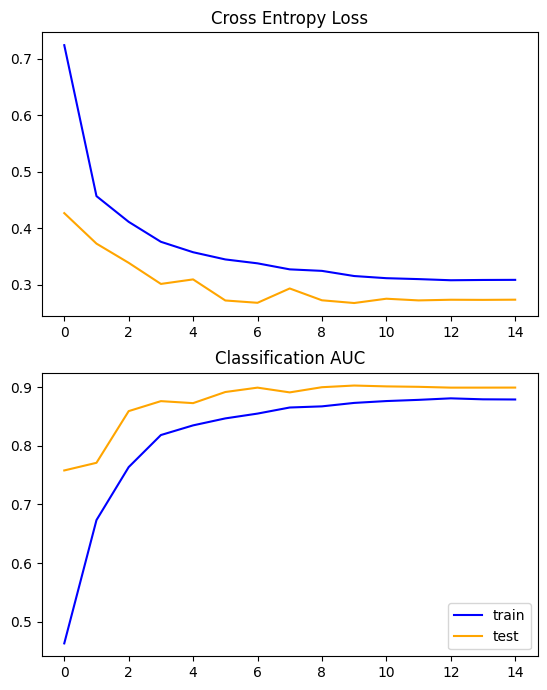

In [ ]:
summarize_diagnostics(history)

In [ ]:
make_submission('25-12-22.csv', 0.6)

157/157 [==============================] - 1s 9ms/step


In [18]:
text = '''
Aug_size = 3000
scale = minmax
threshold = 0.6


initializer = 'he_uniform'
def build_model_2():
    Create a model as a list of layers.
    
    This function returns a sequential VGG-type model as a list of stacked layers.

    Returns
    -------
    keras.engine.sequential.Sequential
        A sequential model.
    model =Sequential()

    model.add(Conv2D(64/2, kernel_size=(5,1), activation='relu', padding='same', input_shape=(64, 64, 1), kernel_initializer=initializer))
    model.add(Conv2D(64/2, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(128/2, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(128/2, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(256/2, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(256/2, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(512/2, kernel_size=(5,1), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(512/2, kernel_size=(1,5), activation='relu', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((3,3), strides=2, padding='same')) 
    model.add(Dropout(rate=0.25))

    model.add(Flatten())    
    model.add(Dense(1024/2, activation='relu'))   
    model.add(Dropout(rate=0.5))    
    model.add(Dense(3, activation='sigmoid'))

    return model
    
    '''

In [19]:
info('25-12-22', text)

# Rough Stuff

In [2]:
import pandas as pd
df = pd.read_csv(os.path.join(os.getcwd(), 'dl-2022-medical', 'train_labels.csv'))
mask = (df[ 'label3'] == 0) & (df[ 'label2'] == 0) & (df[ 'label1'] == 0)
mask_1 = (df[ 'label2'] == 1) & (df[ 'label3'] == 1)
mask_12= (df[ 'label1'] == 0)

In [8]:
df['label1'].value_counts(normalize=True)

0    0.536333
1    0.463667
Name: label1, dtype: float64

In [7]:
df['label2'].value_counts(normalize=True)

0    0.638833
1    0.361167
Name: label2, dtype: float64

In [59]:
len(set(df[mask].index).intersection(set(index)))

2965

In [9]:
df['label3'].value_counts(normalize=True)

0    0.773333
1    0.226667
Name: label3, dtype: float64

In [60]:
rem = sorted((set(df[mask].index).intersection(set(index))), reverse=True)

In [ ]:
#images = []
counter = 0
index = []
for path in train_image_paths:
    image = cv2.imread(path, 0)
    if image.mean() == 0:
        print(counter)
        index.append(counter)
    counter += 1  